In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define Paths
dataset_path = "C:\\Users\\sangeetha\\1\\Alzheimer"  # Main dataset folder
output_dir = "C:\\Users\\sangeetha\\1\\alzheimer_mri"  # Output directory

# Create output folders
for split in ['train', 'val', 'test']:
    for category in os.listdir(dataset_path):
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Split Data
for category in os.listdir(dataset_path):
    img_list = os.listdir(os.path.join(dataset_path, category))
    
    # Split into Train (70%), Test (20%), and Validation (10%)
    train_imgs, test_imgs = train_test_split(img_list, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(test_imgs, test_size=2/3, random_state=42)

    # Move Images
    for img in train_imgs:
        shutil.move(os.path.join(dataset_path, category, img),
                    os.path.join(output_dir, 'train', category, img))
    for img in val_imgs:
        shutil.move(os.path.join(dataset_path, category, img),
                    os.path.join(output_dir, 'val', category, img))
    for img in test_imgs:
        shutil.move(os.path.join(dataset_path, category, img),
                    os.path.join(output_dir, 'test', category, img))

print("Dataset split completed!")


Dataset split completed!


In [5]:
for split in ['train', 'val', 'test']:
    print(f"{split} data:")
    for category in os.listdir(os.path.join(output_dir, split)):
        print(f"  {category}: {len(os.listdir(os.path.join(output_dir, split, category)))} images")


train data:
  Mild Dementia: 3501 images
  Moderate Dementia: 341 images
  Non Demented: 47055 images
  Very mild Dementia: 9607 images
val data:
  Mild Dementia: 500 images
  Moderate Dementia: 49 images
  Non Demented: 6722 images
  Very mild Dementia: 1372 images
test data:
  Mild Dementia: 1001 images
  Moderate Dementia: 98 images
  Non Demented: 13445 images
  Very mild Dementia: 2746 images


In [1]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [2]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define data directories
dataset_path  = "C:\\Users\\sangeetha\\1\\alzheimer_mri"

train_path = "C:\\Users\\sangeetha\\1\\alzheimer_mri\\train"
test_path = "C:\\Users\\sangeetha\\1\\alzheimer_mri\\test"
val_path="C:\\Users\\sangeetha\\1\\alzheimer_mri\\val"


# Load image paths
train_paths = glob(f"{train_path}/*/*.png") + glob(f"{train_path}/*/*.jpeg") + glob(f"{train_path}/*/*.jpg")
val_paths = glob(f"{val_path}/*/*.png") + glob(f"{val_path}/*/*.jpeg")+ glob(f"{val_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.png") + glob(f"{test_path}/*/*.jpeg")+glob(f"{test_path}/*/*.jpg")



In [3]:
# check device
device

'cpu'

In [4]:

# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [6]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset=dataset(val_paths, transform=test_transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
print(f"Train images found: {len(train_paths)}")
print(f"Test images found: {len(test_paths)}")
print(f"Validation images found: {len(val_paths)}")


Train images found: 60504
Test images found: 17290
Validation images found: 8643


In [9]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

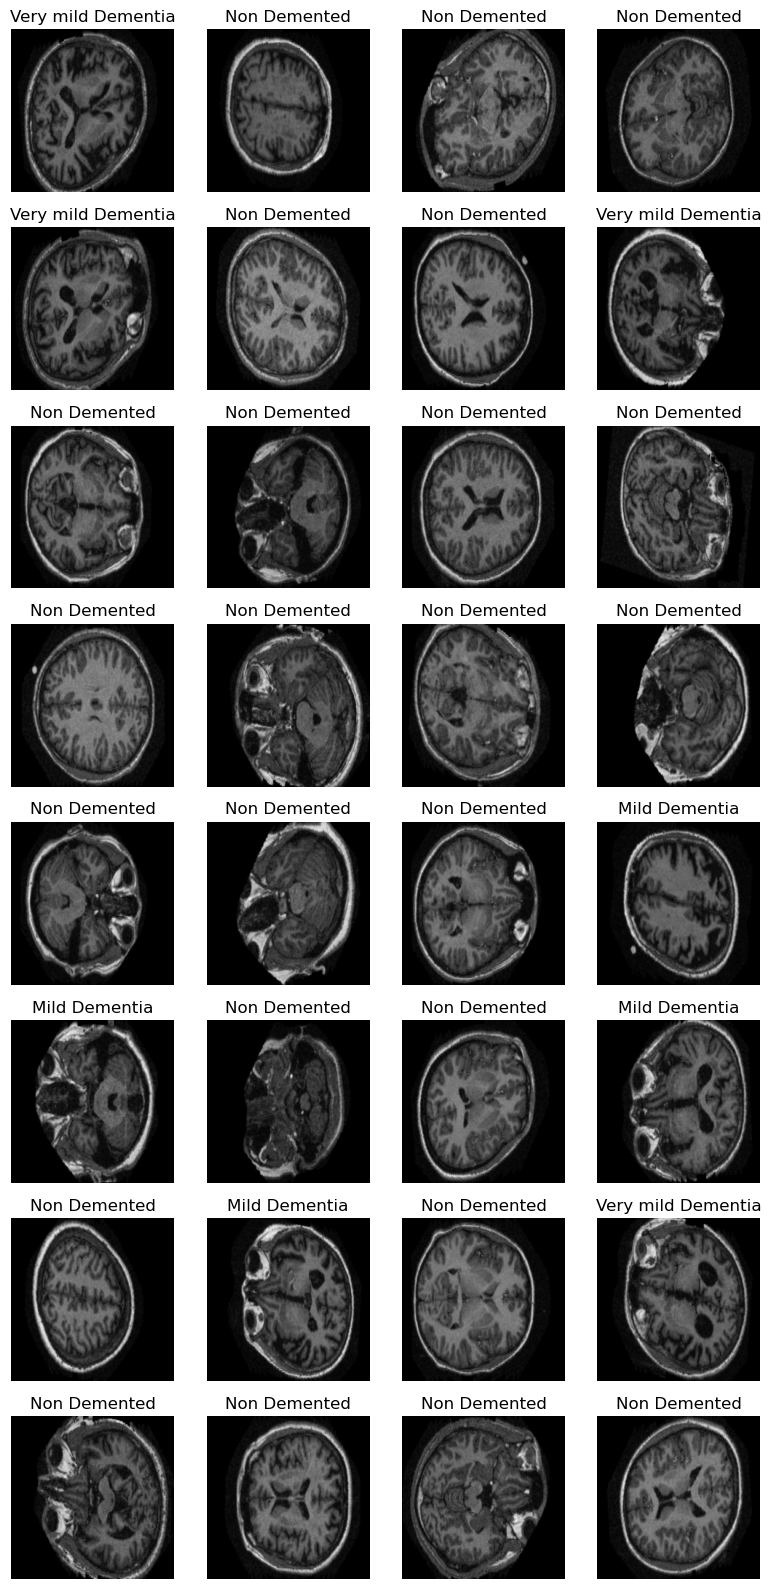

In [10]:
# display sample images with classes
train_iter = iter(train_loader)
images, labels_indices, labels = next(train_iter)

def imshow(input_images, labels_indices,labels):
    label_dict = {"Mild Dementia":"Mild Dementia", "Moderate Dementia":"Moderate Dementia", "Non Demented":"Non Demented","Very mild Dementia":"Very mild Dementia"}
    input_images=input_images.numpy().transpose((0,2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    fig, axes = plt.subplots(8, 4, figsize=(8, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(input_images[i])
        ax.axis('off')
        ax.set_title(label_dict[labels[i]], fontsize=12)
    plt.tight_layout()
    plt.show()


imshow(images, labels_indices,labels)

In [11]:
# Get unique labels
unique_labels = set(train_dataset.labels)  # Extract unique labels from the training dataset
print("Class Labels:", unique_labels)


Class Labels: {'Non Demented', 'Mild Dementia', 'Very mild Dementia', 'Moderate Dementia'}


In [12]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
num_classes=4
model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)

In [14]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [15]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [16]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [17]:
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"modelalzhe_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

Epoch 0,   Batch 150/1891, Loss: 0.5687, Accuracy: 77.65%
Batch 300/1891, Loss: 0.5347, Accuracy: 78.29%
Batch 450/1891, Loss: 0.5164, Accuracy: 78.67%
Batch 600/1891, Loss: 0.5039, Accuracy: 78.99%
Batch 750/1891, Loss: 0.4933, Accuracy: 79.32%
Batch 900/1891, Loss: 0.4864, Accuracy: 79.42%
Batch 1050/1891, Loss: 0.4781, Accuracy: 79.69%
Batch 1200/1891, Loss: 0.4705, Accuracy: 79.92%
Batch 1350/1891, Loss: 0.4634, Accuracy: 80.22%
Batch 1500/1891, Loss: 0.4543, Accuracy: 80.58%
Batch 1650/1891, Loss: 0.4459, Accuracy: 80.92%
Batch 1800/1891, Loss: 0.4394, Accuracy: 81.19%
Train Loss: 0.4351, Train Accuracy: 81.39%
Eval Loss: 0.5096, Eval Accuracy: 75.63%
######################################################################
Epoch 1,   Batch 150/1891, Loss: 0.3590, Accuracy: 85.12%
Batch 300/1891, Loss: 0.3473, Accuracy: 85.48%
Batch 450/1891, Loss: 0.3385, Accuracy: 85.95%
Batch 600/1891, Loss: 0.3323, Accuracy: 86.06%
Batch 750/1891, Loss: 0.3255, Accuracy: 86.36%
Batch 900/1891, Lo

KeyboardInterrupt: 

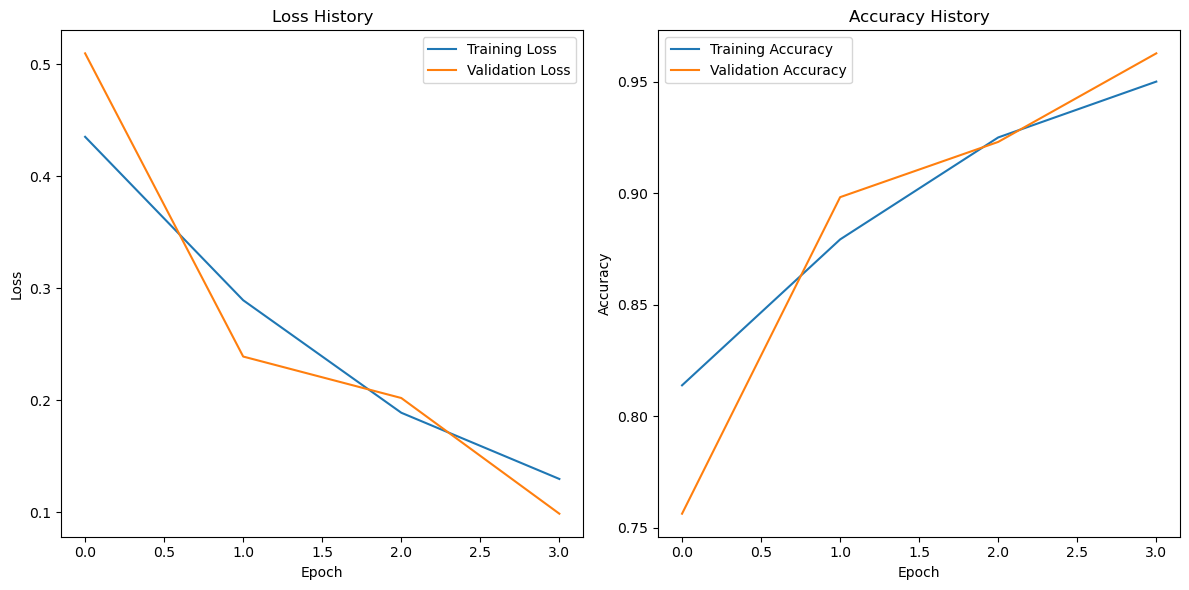

In [18]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [19]:
models = glob("C:\\Users\\sangeetha\\modelalzhe_*")
print("Found models:", models)

Found models: ['C:\\Users\\sangeetha\\modelalzhe_1', 'C:\\Users\\sangeetha\\modelalzhe_2', 'C:\\Users\\sangeetha\\modelalzhe_3', 'C:\\Users\\sangeetha\\modelalzhe_4']


In [20]:

# Extract only numeric model numbers
model_num = [
    int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()
]

if model_num:
    best_model_path = "C:\\Users\\sangeetha\\modelalzhe_" + str(max(model_num))
    print("Best model path:", best_model_path)
else:
    print("No valid numeric model files found.")

Best model path: C:\Users\sangeetha\modelalzhe_4


In [21]:
best_model = MyModel(num_classes).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))

C:\Users\sangeetha\AppData\Local\Temp\ipykernel_5192\1382705795.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, ma

<All keys matched successfully>

In [22]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [23]:
best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

17290

In [24]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)

17290

In [25]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")


Best Model Test Accuracy: 96.47%


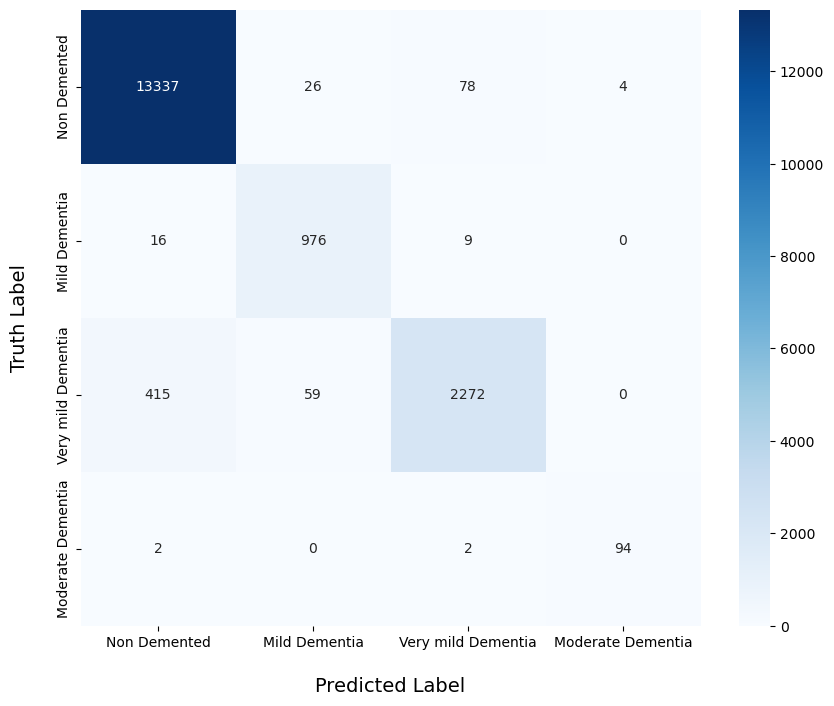

In [26]:
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()

In [27]:
model = MyModel(num_classes).to(device)
model.load_state_dict(torch.load("C:\\Users\\sangeetha\\modelalzhe_4"))  # Replace with the correct model file name
model.eval()  # Set the model to evaluation mode


C:\Users\sangeetha\AppData\Local\Temp\ipykernel_5192\1415742354.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:\\Users\\sangeetha\\m

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, in

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    return image.to(device)


In [29]:
label_dict = {
    
    0:"Non Demented",
    1: "Mild Dementia",
    2:"Very mild Dementia",
    3:"Moderate Dementia",
   
  
  
}

def predict(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index
    return label_dict[predicted.item()]  # Return the class name

In [30]:
image_path = "C:\\Users\\sangeetha\\1\\alzheimer_mri\\test\\Mild Dementia\\OAS1_0028_MR1_mpr-1_147.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")

Predicted  Type: Mild Dementia


In [31]:

image_path = "C:\\Users\\sangeetha\\1\\alzheimer_mri\\test\\Moderate Dementia\\OAS1_0351_MR1_mpr-4_123.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")

Predicted  Type: Moderate Dementia


In [32]:

image_path = "C:\\Users\\sangeetha\\1\\alzheimer_mri\\test\\Very mild Dementia\\OAS1_0003_MR1_mpr-2_107.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")

Predicted  Type: Very mild Dementia


In [33]:
image_path = "C:\\Users\\sangeetha\\1\\alzheimer_mri\\test\\Non Demented\\OAS1_0005_MR1_mpr-4_138.jpg"  # Change this to your test image path
prediction = predict(image_path)
print(f"Predicted  Type: {prediction}")

Predicted  Type: Non Demented
